
# Adaptive Sampling Simulation — DDASA vs Kalman-Driven Scheduling

Notebook ini mensimulasikan dua pendekatan **adaptive sampling** pada data sensor waktu-nyata:
1. **DDASA (Data-Driven Adaptive Sampling Algorithm)** — penjadwalan sampling berbasis perubahan data aktual (rolling statistik).
2. **Kalman Residual Scheduling (KRS)** — penjadwalan sampling dengan memanipulasi *interval waktu* berdasarkan **residual** (_e_k_) Kalman Filter.

Kita akan membandingkan **akurasi rekonstruksi**, **error (MAE, RMSE)**, **jumlah sample** (proxy energi), **interval sampling**, dan **delay deteksi event**. Ground truth diambil dari berkas CSV ber-sampling rapat; setiap strategi memilih subset waktu sampling, lalu kita rekonstruksi sinyal penuh via interpolasi linier untuk evaluasi.

> Path data: `/mnt/data/sensor_data_simulasi.csv`


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from typing import Dict, List, Tuple

# Jangan gunakan seaborn (sesuai aturan tool)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

def ensure_time_axis(df: pd.DataFrame) -> pd.DataFrame:
    """Pastikan ada sumbu waktu yang seragam.
    - Coba deteksi kolom 'time' / 'timestamp' / 't' (case-insensitive)
    - Jika ada datetime, konversi ke detik relatif (float s) dari awal
    - Jika tidak ada, gunakan index sebagai waktu (dt=1 satuan, relatif).
    """
    cols = {c.lower(): c for c in df.columns}
    time_col = None
    for cand in ['time', 'timestamp', 't']:
        if cand in cols:
            time_col = cols[cand]
            break

    if time_col is not None:
        # Coba parse datetime; jika gagal, treat as numeric
        try:
            t = pd.to_datetime(df[time_col])
            t0 = t.iloc[0]
            sec = (t - t0).dt.total_seconds().astype(float)
            df = df.copy()
            df['_t'] = sec.values
        except Exception:
            # treat as numeric
            sec = df[time_col].astype(float).values
            order = np.argsort(sec)
            df = df.iloc[order].reset_index(drop=True).copy()
            df['_t'] = np.sort(sec)
    else:
        # Pakai index (0..N-1)
        df = df.copy()
        df['_t'] = np.arange(len(df), dtype=float)

    # Pastikan terurut w.r.t waktu
    df = df.sort_values('_t').reset_index(drop=True)
    return df


def pick_sensor_column(df: pd.DataFrame) -> str:
    """Pilih satu kolom numerik (selain _t) sebagai sinyal utama untuk simulasi.
    Prioritas: kolom bernama umum, jika tidak ambil kolom numerik pertama.
    """
    candidates = [c for c in df.columns if c != '_t']
    preferred = ['temperature','temp','do','ph','salinity','sensor','value','val','y']
    cand_lower = {c.lower(): c for c in candidates}
    for p in preferred:
        if p in cand_lower:
            return cand_lower[p]
    for c in candidates:
        if pd.api.types.is_numeric_dtype(df[c]):
            return c
    raise ValueError("Tidak menemukan kolom sensor numerik yang cocok.")


def linear_reconstruct(t_full: np.ndarray, t_s: np.ndarray, x_s: np.ndarray) -> np.ndarray:
    """Rekonstruksi sinyal pada t_full dari sampel (t_s, x_s) via interpolasi linier."""
    if len(t_s) == 0:
        return np.zeros_like(t_full, dtype=float)
    if len(t_s) == 1:
        return np.full_like(t_full, fill_value=x_s[0], dtype=float)
    return np.interp(t_full, t_s, x_s)


def compute_errors(x_true: np.ndarray, x_rec: np.ndarray) -> Dict[str, float]:
    e = x_true - x_rec
    mae = float(np.mean(np.abs(e)))
    rmse = float(np.sqrt(np.mean(e**2)))
    mape = float(np.mean(np.abs(e) / (np.abs(x_true) + 1e-9))) * 100.0
    return {"MAE": mae, "RMSE": rmse, "MAPE_%": mape}


def detect_events(x: np.ndarray, q: float = 0.9) -> np.ndarray:
    """Deteksi 'event' berbasis ambang derivatif absolut (|dx|) pada kuantil q.
    Return: indeks event onset (boolean mask ukuran N)."""
    dx = np.diff(x, prepend=x[0])
    thr = np.quantile(np.abs(dx), q)
    event_mask = np.abs(dx) >= thr
    onset = np.zeros_like(event_mask, dtype=bool)
    prev = False
    for i, m in enumerate(event_mask):
        if m and not prev:
            onset[i] = True
        prev = m
    return onset


def event_detection_delay(t: np.ndarray, event_onset: np.ndarray, sample_idx: List[int]) -> Tuple[float, int]:
    """Hitung delay rata-rata dari onset event ke waktu sample berikutnya.
    Return: (avg_delay, count) dalam satuan waktu t.
    """
    if not np.any(event_onset) or len(sample_idx) == 0:
        return (np.nan, 0)
    onset_idx = np.where(event_onset)[0]
    delays = []
    for oi in onset_idx:
        cand = [si for si in sample_idx if si >= oi]
        if len(cand) == 0:
            continue
        si = cand[0]
        delays.append(t[si] - t[oi])
    if len(delays) == 0:
        return (np.nan, 0)
    return (float(np.mean(delays)), len(delays))


class ScalarKalman:
    """Kalman Filter skalar: model random-walk x_k = x_{k-1} + w; z_k = x_k + v."""
    def __init__(self, x0: float, P0: float = 1.0, Q: float = 0.01, R: float = 0.25):
        self.x = float(x0)
        self.P = float(P0)
        self.Q = float(Q)
        self.R = float(R)

    def predict(self, dt: float = 1.0):
        # Random-walk: x = x; P = P + Q*dt
        self.P = self.P + self.Q * max(dt, 1e-9)

    def update(self, z: float):
        K = self.P / (self.P + self.R)
        self.x = self.x + K * (z - self.x)
        self.P = (1.0 - K) * self.P
        return float(z - self.x), float(K)  # residual (post-update) & Kalman gain


def ddasa_schedule(t: np.ndarray, x: np.ndarray, min_step: int, mid_step: int, max_step: int,
                   win: int = 30, q_high: float = 0.9, q_low: float = 0.3) -> List[int]:
    """Penjadwalan DDASA.
    - Rolling window untuk distribusi |Δx|.
    - dev tinggi -> min_step; dev rendah -> max_step; lainnya -> mid_step.
    Return: indeks sampling (urut naik).
    """
    N = len(x)
    i = 0
    idx = [i]
    while i < N-1:
        left = max(0, i - win + 1)
        ref = np.median(x[left:i+1]) if i > 0 else x[0]
        dev = abs(x[i] - ref)

        if i > 0:
            dseg = np.abs(np.diff(x[left:i+1], prepend=x[left]))
        else:
            dseg = np.array([0.0])
        thr_hi = np.quantile(dseg, q_high) if len(dseg) > 1 else 0.0
        thr_lo = np.quantile(dseg, q_low)  if len(dseg) > 1 else 0.0

        if dev >= thr_hi:
            step = min_step
        elif dev <= thr_lo:
            step = max_step
        else:
            step = mid_step

        i = min(N-1, i + step)
        if idx[-1] != i:
            idx.append(i)
    return idx


def krs_schedule(t: np.ndarray, x: np.ndarray, min_step: int, mid_step: int, max_step: int,
                 Q: float = 0.02, R: float = 0.25, q_high: float = 0.9, q_low: float = 0.3) -> List[int]:
    """Penjadwalan Kalman Residual Scheduling (KRS).
    - Residual besar -> min_step (fMax), residual kecil -> max_step (fMin).
    - Ambang adaptif pakai kuantil dari residual sejarah.
    """
    N = len(x)
    i = 0
    idx = [i]
    kf = ScalarKalman(x0=float(x[0]), P0=1.0, Q=Q, R=R)
    residual_hist: List[float] = []

    while i < N-1:
        z = float(x[i])
        kf.predict(dt=1.0)
        e_pre = z - kf.x  # residual pre-update (approx)
        e_post, _ = kf.update(z)

        residual_hist.append(abs(e_pre))
        if len(residual_hist) >= 10:
            thr_hi = float(np.quantile(residual_hist, q_high))
            thr_lo = float(np.quantile(residual_hist, q_low))
        else:
            # fallback awal
            diffs = np.abs(np.diff(x[:max(i+1,2)], prepend=x[0]))
            thr_hi = float(np.quantile(diffs, q_high)) if len(diffs) else 0.0
            thr_lo = float(np.quantile(diffs, q_low))  if len(diffs) else 0.0

        if abs(e_pre) >= thr_hi:
            step = min_step
        elif abs(e_pre) <= thr_lo:
            step = max_step
        else:
            step = mid_step

        i = min(N-1, i + step)
        if idx[-1] != i:
            idx.append(i)
    return idx


def fixed_interval_schedule(N: int, step: int) -> List[int]:
    step = max(1, int(step))
    idx = list(range(0, N, step))
    if len(idx) == 0 or idx[-1] != N-1:
        idx.append(N-1)
    return idx


In [3]:

# --- Konfigurasi path data ---
DATA_PATH = '/home/wgg/proyek-jupyter/Adaptive-Sampling/sensor_data_simulasi.csv'

# Load
df_raw = pd.read_csv(DATA_PATH)

# Pastikan ada waktu
df = ensure_time_axis(df_raw)

# Pilih kolom sensor (numerik)
sensor_col = pick_sensor_column(df)
print("Kolom sensor terpilih:", sensor_col)

# Ground truth arrays
t = df['_t'].to_numpy(dtype=float)
x = df[sensor_col].astype(float).to_numpy()

N = len(x)
print("Jumlah data:", N)
df.head()


Kolom sensor terpilih: Waktu Relatif (s)
Jumlah data: 100


,Waktu Relatif (s),Nilai Sensor,_t
0,0.000,24.09,0.0
1,0.100,28.29,1.0
2,0.200,29.04,2.0
3,0.301,22.25,3.0
4,0.401,21.07,4.0


In [4]:

# ============================================================
# Parameter Simulasi & Hyperparameters
# ============================================================
# min_step: sampling tercepat (frekuensi maksimum, fMax)
# max_step: sampling terlambat (frekuensi minimum, fMin)
min_step = 1     # fMax: ambil setiap sample
mid_step = 5     # intermediate
max_step = 20    # fMin: ambil setiap 20 sample

# Baseline fixed interval
fixed_step = 10

# DDASA window dan kuantil
ddasa_win = 30
ddasa_q_high = 0.9
ddasa_q_low = 0.3

# Kalman filter (random-walk) noise
kf_Q = 0.02
kf_R = 0.25
krs_q_high = 0.9
krs_q_low = 0.3

# Event detection threshold (untuk menghitung detection delay)
event_q = 0.9

# Biaya energi per 1 sample (proxy)
energy_per_sample = 1.0
# ============================================================


In [5]:

# Jadwalkan sampling
idx_fixed = fixed_interval_schedule(N, fixed_step)
idx_ddasa = ddasa_schedule(t, x, min_step=min_step, mid_step=mid_step, max_step=max_step,
                           win=ddasa_win, q_high=ddasa_q_high, q_low=ddasa_q_low)
idx_krs   = krs_schedule(t, x, min_step=min_step, mid_step=mid_step, max_step=max_step,
                         Q=kf_Q, R=kf_R, q_high=krs_q_high, q_low=krs_q_low)

# Sampel & rekonstruksi
t_fixed, x_fixed = t[idx_fixed], x[idx_fixed]
t_ddasa, x_ddasa = t[idx_ddasa], x[idx_ddasa]
t_krs,   x_krs   = t[idx_krs],   x[idx_krs]

xrec_fixed = linear_reconstruct(t, t_fixed, x_fixed)
xrec_ddasa = linear_reconstruct(t, t_ddasa, x_ddasa)
xrec_krs   = linear_reconstruct(t, t_krs,   x_krs)

# Error metrics
err_fixed = compute_errors(x, xrec_fixed)
err_ddasa = compute_errors(x, xrec_ddasa)
err_krs   = compute_errors(x, xrec_krs)

# Event detection & delay
event_onset = detect_events(x, q=event_q)
delay_fixed, count_fixed = event_detection_delay(t, event_onset, idx_fixed)
delay_ddasa, count_ddasa = event_detection_delay(t, event_onset, idx_ddasa)
delay_krs,   count_krs   = event_detection_delay(t, event_onset, idx_krs)

# Tabel ringkas
def summarize(name, idx, err, delay, count):
    intervals = np.diff(np.array(idx)) if len(idx) > 1 else np.array([np.nan])
    return {
        'Metode': name,
        'N_sample': int(len(idx)),
        'Rasio_sampling_%': 100.0 * len(idx) / len(t),
        'Interval_mean': float(np.nanmean(intervals)),
        'Interval_median': float(np.nanmedian(intervals)),
        'MAE': err['MAE'],
        'RMSE': err['RMSE'],
        'MAPE_%': err['MAPE_%'],
        'Event_delay_mean_time': delay,
        'Event_delay_count': int(count),
        'Energi_proxy': float(len(idx) * energy_per_sample)
    }

summary = pd.DataFrame([
    summarize('Fixed-Interval', idx_fixed, err_fixed, delay_fixed, count_fixed),
    summarize('DDASA',          idx_ddasa, err_ddasa, delay_ddasa, count_ddasa),
    summarize('Kalman-Residual',idx_krs,   err_krs,   delay_krs,   count_krs)
])

summary


,Metode,N_sample,Rasio_sampling_%,Interval_mean,Interval_median,MAE,RMSE,MAPE_%,Event_delay_mean_time,Event_delay_count,Energi_proxy
0,Fixed-Interval,11,11.0,9.900000,10.0,0.000278,0.000343,0.014288,4.526316,19,11.0
1,DDASA,96,96.0,1.042105,1.0,0.000014,0.000077,0.004390,0.157895,19,96.0
2,Kalman-Residual,23,23.0,4.500000,4.5,0.000249,0.000328,0.013061,5.315789,19,23.0



## Visualisasi
Plot di bawah ini menampilkan sinyal ground-truth dan titik sampling untuk setiap metode, serta rekonstruksi linier.


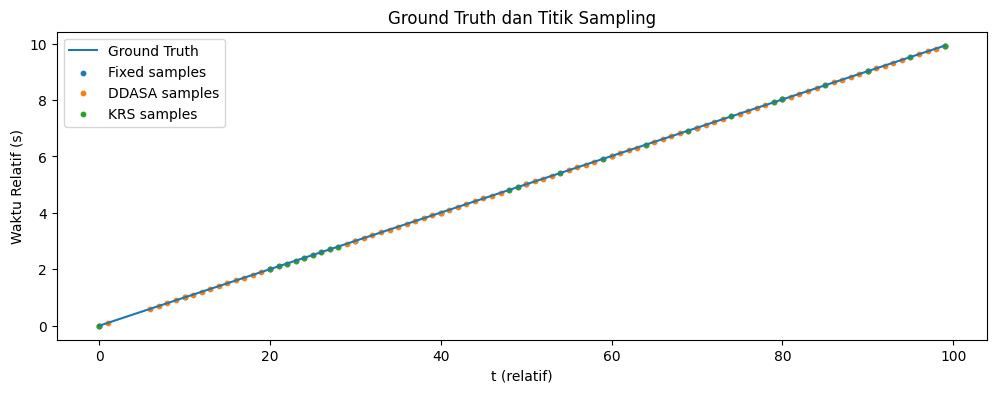

In [6]:

# Plot 1: Ground truth + Sampling points
plt.figure(figsize=(12, 4))
plt.plot(t, x, label='Ground Truth')
plt.scatter(t_fixed, x_fixed, s=10, label='Fixed samples')
plt.scatter(t_ddasa, x_ddasa, s=10, label='DDASA samples')
plt.scatter(t_krs, x_krs, s=10, label='KRS samples')
plt.title('Ground Truth dan Titik Sampling')
plt.xlabel('t (relatif)')
plt.ylabel(sensor_col)
plt.legend()
plt.show()


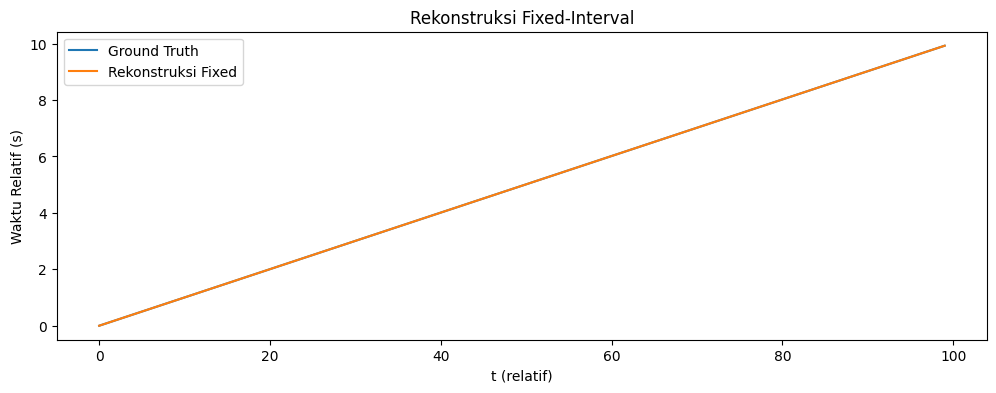

In [7]:

# Plot 2: Rekonstruksi vs Ground truth (Fixed)
plt.figure(figsize=(12, 4))
plt.plot(t, x, label='Ground Truth')
plt.plot(t, xrec_fixed, label='Rekonstruksi Fixed')
plt.title('Rekonstruksi Fixed-Interval')
plt.xlabel('t (relatif)')
plt.ylabel(sensor_col)
plt.legend()
plt.show()


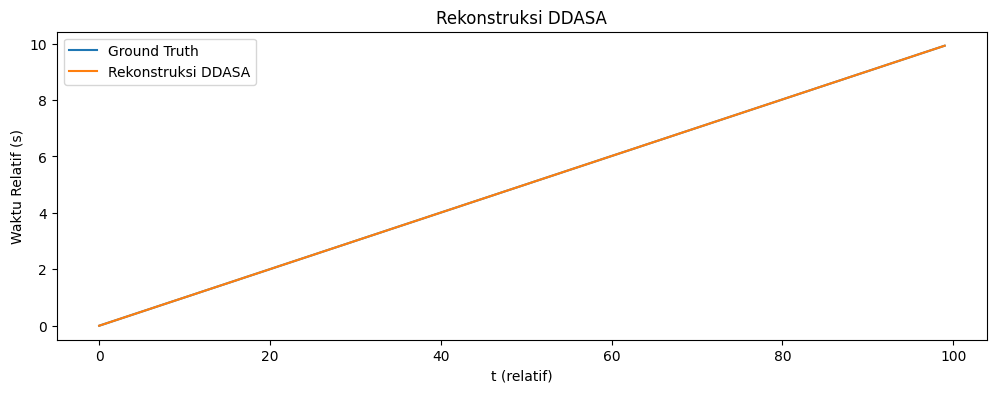

In [8]:

# Plot 3: Rekonstruksi vs Ground truth (DDASA)
plt.figure(figsize=(12, 4))
plt.plot(t, x, label='Ground Truth')
plt.plot(t, xrec_ddasa, label='Rekonstruksi DDASA')
plt.title('Rekonstruksi DDASA')
plt.xlabel('t (relatif)')
plt.ylabel(sensor_col)
plt.legend()
plt.show()


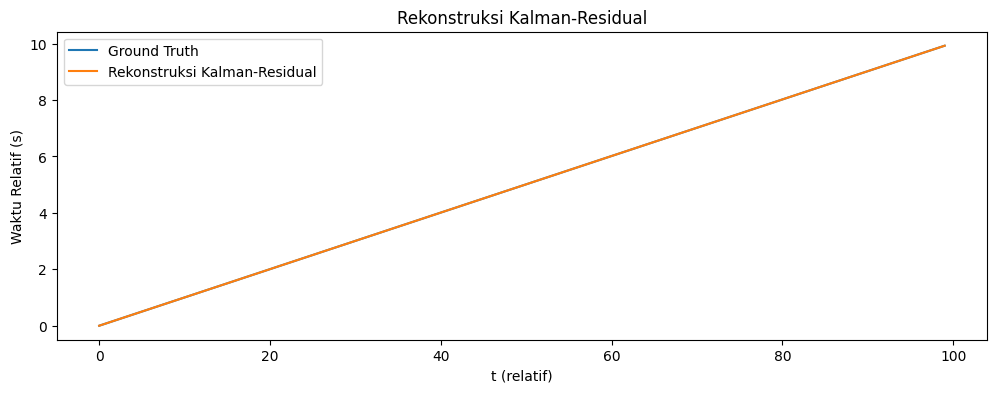

In [9]:

# Plot 4: Rekonstruksi vs Ground truth (Kalman Residual Scheduling)
plt.figure(figsize=(12, 4))
plt.plot(t, x, label='Ground Truth')
plt.plot(t, xrec_krs, label='Rekonstruksi Kalman-Residual')
plt.title('Rekonstruksi Kalman-Residual')
plt.xlabel('t (relatif)')
plt.ylabel(sensor_col)
plt.legend()
plt.show()



## Eksperimen Sensitivitas (Opsional)
Ubah parameter di sel **Parameter Simulasi** (misalnya `min_step`, `mid_step`, `max_step`, `kf_Q`, `kf_R`, kuantil `q_high`/`q_low`) lalu jalankan ulang bagian **Run schedules** untuk melihat dampaknya pada jumlah sampling dan akurasi.


In [10]:

# Ringkasan lengkap dalam satu tampilan
print("\n=== RINGKASAN PERBANDINGAN ===")
display(summary)

print("\nCatatan:")
print("- 'Rasio_sampling_%' semakin kecil berarti penghematan sampling/energi semakin baik.")
print("- Perhatikan trade-off antara error (MAE/RMSE/MAPE) vs jumlah sampel.")
print("- 'Event_delay_mean_time' menunjukkan rata-rata jeda waktu dari awal event hingga sampel berikutnya.")



=== RINGKASAN PERBANDINGAN ===


,Metode,N_sample,Rasio_sampling_%,Interval_mean,Interval_median,MAE,RMSE,MAPE_%,Event_delay_mean_time,Event_delay_count,Energi_proxy
0,Fixed-Interval,11,11.0,9.900000,10.0,0.000278,0.000343,0.014288,4.526316,19,11.0
1,DDASA,96,96.0,1.042105,1.0,0.000014,0.000077,0.004390,0.157895,19,96.0
2,Kalman-Residual,23,23.0,4.500000,4.5,0.000249,0.000328,0.013061,5.315789,19,23.0



Catatan:
- 'Rasio_sampling_%' semakin kecil berarti penghematan sampling/energi semakin baik.
- Perhatikan trade-off antara error (MAE/RMSE/MAPE) vs jumlah sampel.
- 'Event_delay_mean_time' menunjukkan rata-rata jeda waktu dari awal event hingga sampel berikutnya.



## Mekanisme Pemicuan Adaptif (Sesuai Instruksi)

**Jika Kesalahan Prediksi (e_k) Tinggi** (residual KF besar):  
- Artinya prediksi model tidak cocok dengan pengukuran terkini → ada perubahan signifikan / anomali.  
- **Tindakan:** Atur interval ke `min_step` (frekuensi maksimum, *fMax*) untuk merekam perubahan dengan resolusi tinggi.

**Jika Kesalahan Prediksi (e_k) Rendah** (residual KF kecil):  
- Lingkungan stabil, prediksi akurat.  
- **Tindakan:** Atur interval ke `max_step` (frekuensi minimum, *fMin*) agar hemat energi tanpa kehilangan akurasi rekonstruksi.

**DDASA (Data-Driven):**  
- Tidak menggunakan model KF, tetapi memakai statistik _rolling_ dari perubahan sinyal (`|Δx|`).  
- Jika deviasi terhadap median/ambang kuantil tinggi → percepat sampling (`min_step`).  
- Jika deviasi rendah → perlambat sampling (`max_step`).  
- Selain itu → `mid_step`.
